# KerasCV의 Segment Anything

**저자:** Tirth Patel, Ian Stenbit  
**생성일:** 2023/12/04  
**최종편집일:** 2023/12/19  
**설명:** KerasCV에서, 텍스트, 상자, 포인트 프롬프트를 사용한 Segment Anything.

## 개요

Segment Anything Model(SAM)은 점이나 상자와 같은 입력 프롬프트에서 고품질 객체 마스크를 생성하며,
이미지의 모든 객체에 대한 마스크를 생성하는 데 사용할 수 있습니다.
1,100만 개의 이미지와 11억 개의 마스크로 구성된 [데이터 세트](https://segment-anything.com/dataset/index.html)에 대해 트레이닝되었으며,
다양한 세그멘테이션 작업에서 강력한 제로샷 성능을 보입니다.

이 가이드에서는, KerasCV의 [Segment Anything Model](https://github.com/facebookresearch/segment-anything) 구현을 사용하는 방법과,
TensorFlow와 JAX의 성능 향상이 얼마나 강력한지 보여드리겠습니다.

먼저 데모를 위한 모든 종속성과 이미지를 가져오겠습니다.

In [1]:
# 이 노트북은 Keras cv가 설치되어 있다는 가정 하에 진행됩니다.
# 이 노트북은 Keras 3이 설치되어 있다는 가정 하에 진행됩니다.
#
# !pip install -q --upgrade keras-cv
# !pip install -q --upgrade keras  # Upgrade to Keras 3.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"

In [3]:
from keras import backend

print(backend.backend())

tensorflow


In [4]:
import keras

print(keras.__version__)

3.4.1


In [5]:
!wget -q https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg

## 백엔드 선택

Keras 3를 사용하면, 원하는 백엔드를 선택할 수 있습니다!

In [6]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import timeit
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import ops
import keras_cv

## 헬퍼 함수

이미지, 프롬프트, 세그멘테이션 결과를 시각화하기 위한, 몇 가지 헬퍼 함수를 정의해 보겠습니다.

In [7]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def inference_resizing(image, pad=True):
    # 전처리 모양 계산
    image = ops.cast(image, dtype="float32")
    old_h, old_w = image.shape[0], image.shape[1]
    scale = 1024 * 1.0 / max(old_h, old_w)
    new_h = old_h * scale
    new_w = old_w * scale
    preprocess_shape = int(new_h + 0.5), int(new_w + 0.5)

    # 이미지 크기 조절
    image = ops.image.resize(image[None, ...], preprocess_shape)[0]

    # 짧은 쪽을 패딩하세요.
    if pad:
        pixel_mean = ops.array([123.675, 116.28, 103.53])
        pixel_std = ops.array([58.395, 57.12, 57.375])
        image = (image - pixel_mean) / pixel_std
        h, w = image.shape[0], image.shape[1]
        pad_h = 1024 - h
        pad_w = 1024 - w
        image = ops.pad(image, [(0, pad_h), (0, pad_w), (0, 0)])
        # KerasCV는 이제 이미지를 재조정(rescales)하고 정규화합니다.
        # KerasCV가 다시 정규화(normalizes)할 때,
        # 패딩된 값이 0으로 매핑되도록, 정규화를 해제(unnormalize)합니다.
        image = image * pixel_std + pixel_mean
    return image

## 사전 트레이닝된 SAM 모델 얻기

KerasCV의 `from_preset` 팩토리 메서드를 사용하여,
트레이닝된 SAM 모델을 초기화할 수 있습니다.
여기서는 고품질 세그먼테이션 마스크를 위해,
SA-1B 데이터 세트(`sam_huge_sa1b`)에 대해 트레이닝된 거대한 ViT 백본을 사용합니다.
더 나은 성능을 위해,
`sam_large_sa1b` 또는 `sam_base_sa1b` 중 하나를 사용할 수도 있습니다.
(세그먼테이션 마스크의 품질이 떨어지는 대가로)

In [8]:
model = keras_cv.models.SegmentAnythingModel.from_preset("sam_huge_sa1b")

100%|██████████| 3.38k/3.38k [00:00<00:00, 945kB/s]
100%|██████████| 2.39G/2.39G [02:17<00:00, 18.7MB/s]


## 프롬프트 이해하기

Segment Anything은 포인트, 상자, 마스크를 사용하여 이미지를 프롬프트할 수 있습니다.

1. 포인트 프롬프트는 가장 기본적인 프롬프트입니다.
   모델은 이미지의 포인트가 주어졌을 때 객체를 추측하려고 합니다.
   포인트는 전경 포인트(즉, 원하는 세그멘테이션 마스크에 포인트가 포함됨)이거나,
   배경 포인트(즉, 포인트가 원하는 마스크 밖에 있음)일 수 있습니다.
2. 모델을 프롬프트하는 또다른 방법은 상자를 사용하는 것입니다.
   경계 상자가 주어졌을 때, 모델은 그 안에 포함된 객체를 세그멘테이션하려고 합니다.
3. 마지막으로, 마스크 자체를 사용하여 모델을 프롬프트할 수도 있습니다.
   예를 들어, 이는 이전에 예측되거나 알려진 세그멘테이션 마스크의 테두리를 정제하는 데 유용합니다.

모델을 엄청나게 강력하게 만드는 것은, 위의 프롬프트를 결합할 수 있는 기능입니다.
포인트, 상자, 마스크 프롬프트는 여러 가지 다른 방법으로 결합하여, 최상의 결과를 얻을 수 있습니다.

KerasCV에서 Segment Anything 모델에 이러한 프롬프트를 전달하는 시맨틱을 살펴보겠습니다.
SAM 모델의 입력은 키가 있는 딕셔너리입니다.

1. `"images"`: 세그멘테이션할 이미지 배치입니다.
   - `(B, 1024, 1024, 3)` 모양이어야 합니다.
2. `"points"`: 포인트 프롬프트 배치입니다.
   - 각 포인트는 이미지의 왼쪽 상단 모서리에서 시작하는 `(x, y)` 좌표입니다.
   - 다른 작업에서, 각 포인트는 `(r, c)` 형태이며, 여기서 `r`과 `c`는 이미지의 픽셀의 행과 열입니다.
   - `(B, N, 2)` 모양이어야 합니다.
3. `"labels"`: 주어진 포인트에 대한 레이블 배치입니다.
   - `1`은 전경 포인트를 나타내고, `0`은 배경 포인트를 나타냅니다.
   - `(B, N)` 모양이어야 합니다.
4. `"boxes"`: 상자 배치입니다.
   - 모델은 배치당 하나의 상자만 허용합니다.
   - 따라서, 예상되는 모양은 `(B, 1, 2, 2)`입니다.
     - 각 상자는 상자의 왼쪽 상단 모서리와 오른쪽 하단 모서리인 2개의 포인트의 모음입니다.
       - 여기의 포인트는 포인트 프롬프트와 동일한 의미를 따릅니다.
     - 여기서 2차원의 `1`은 상자 프롬프트의 존재를 나타냅니다.
       - 상자 프롬프트가 없는 경우, `(B, 0, 2, 2)` 모양의 플레이스홀더 입력을 전달해야 합니다.
5. `"masks"`: 마스크 배치입니다.
   - 상자 프롬프트와 마찬가지로, 이미지당 마스크 프롬프트는 하나만 허용됩니다.
   - 입력 마스크의 모양은 있는 경우, `(B, 1, 256, 256, 1)`이고
   - 마스크 프롬프트가 없는 경우, `(B, 0, 256, 256, 1)`이어야 합니다.

플레이스홀더 프롬프트는 모델을 직접 호출할 때만 필요합니다. (예: `model(...)`)
`predict` 메서드를 호출할 때, 누락된 프롬프트를 입력 딕셔너리에서 생략할 수 있습니다.

## 포인트 프롬프트

먼저, 포인트 프롬프트를 사용하여 이미지를 세그멘테이션해 보겠습니다.
이미지를 로드하고 크기를 조정하여,
사전 트레이닝된 SAM 모델이 예상하는 이미지 크기인,
`(1024, 1024)` 모양으로 만듭니다.

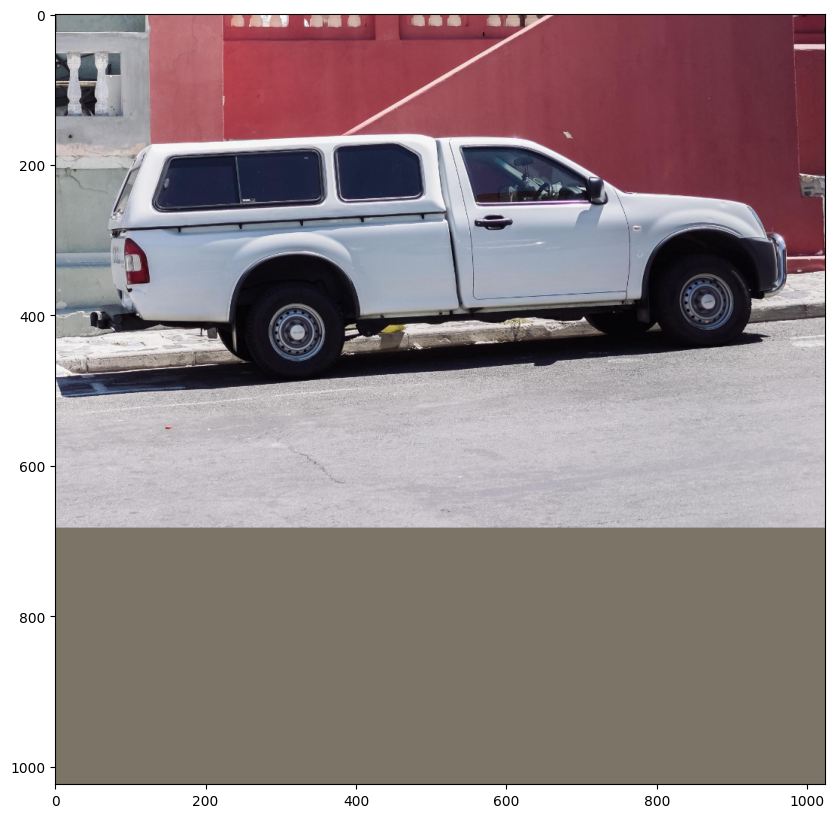

In [9]:
# 이미지를 로드합니다.
image = np.array(keras.utils.load_img("truck.jpg"))
image = inference_resizing(image)

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
plt.axis("on")
plt.show()

다음으로, 세그멘테이션하고자 하는 객체의 포인트를 정의합니다.
트럭의 창문 유리창을 좌표 `(284, 213)`에서 세그멘테이션해 보겠습니다.

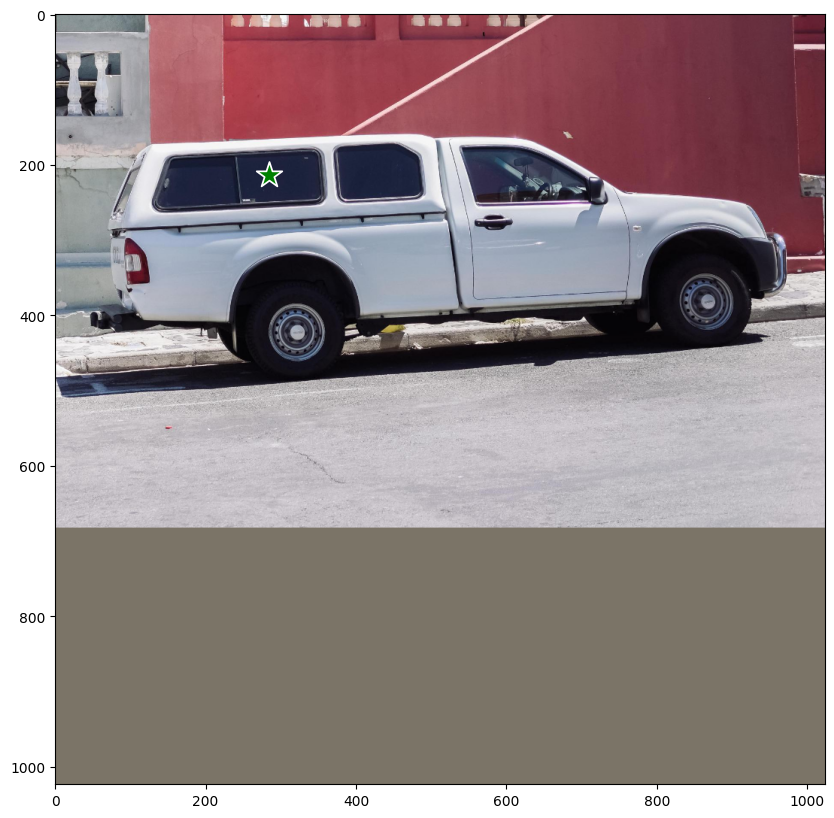

In [10]:
# 입력 포인트 프롬프트 정의
input_point = np.array([[284, 213.5]])
input_label = np.array([1])

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_points(input_point, input_label, plt.gca())
plt.axis("on")
plt.show()

이제, 모델의 `predict` 메서드를 호출하여, 세그멘테이션 마스크를 구해 보겠습니다.

**참고**: 플레이스홀더 프롬프트가 필요하기 때문에, 모델을 직접 호출하지 않습니다. (`model(...)`)
누락된 프롬프트는 predict 메서드에서 자동으로 처리하므로, 대신 호출합니다.
또한, 상자 프롬프트가 없는 경우, 포인트와 레이블은 각각 ​​0 포인트 프롬프트와 `-1` 레이블 프롬프트로 패딩해야 합니다.
아래 셀은 이것이 어떻게 작동하는지 보여줍니다.

In [11]:
outputs = model.predict(
    {
        "images": image[np.newaxis, ...],
        "points": np.concatenate(
            [input_point[np.newaxis, ...], np.zeros((1, 1, 2))], axis=1
        ),
        "labels": np.concatenate(
            [input_label[np.newaxis, ...], np.full((1, 1), fill_value=-1)], axis=1
        ),
    }
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


`SegmentAnythingModel.predict`는 두 개의 출력을 반환합니다.
- 첫 번째는 `(1, 4, 256, 256)` 모양의 로짓(세그멘테이션 마스크)이고,
- 다른 하나는 예측된 각 마스크에 대한 IoU 신뢰도 점수(IoU confidence scores, `(1, 4)` 모양)입니다.

사전 트레이닝된 SAM 모델은 네 개의 마스크를 예측합니다.
- 첫 번째는 모델이 주어진 프롬프트에 대해 생각해 낼 수 있는 최상의 마스크이고,
- 다른 세 개는 최상의 예측에 원하는 개체가 포함되지 않은 경우, 사용할 수 있는 대체 마스크입니다.

사용자는 원하는 마스크를 선택할 수 있습니다.

모델에서 반환된 마스크를 시각화해 보겠습니다!

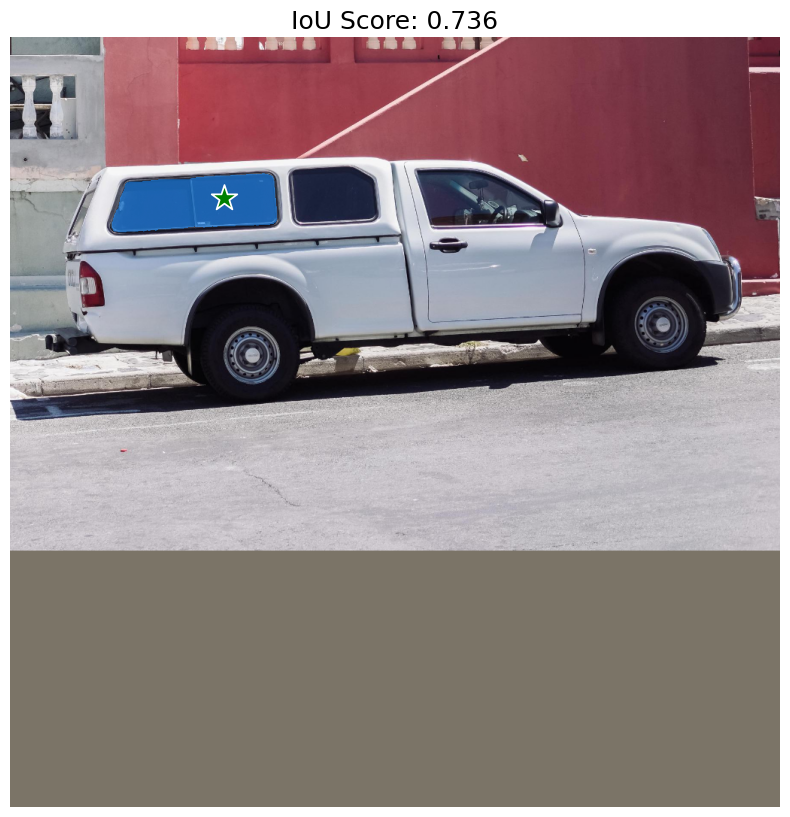

In [12]:
# 마스크 크기를 이미지 모양(1024, 1024)으로 조정합니다.
mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
# 로짓을 numpy 배열로 변환하고, 로짓을 boolean 마스크로 변환합니다.
mask = ops.convert_to_numpy(mask) > 0.0
iou_score = ops.convert_to_numpy(outputs["iou_pred"][0][0])

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"IoU Score: {iou_score:.3f}", fontsize=18)
plt.axis("off")
plt.show()

예상대로, 모델은 트럭의 창 유리창에 대한 세그멘테이션 마스크를 반환합니다.
하지만, 우리의 포인트 프롬프트는 다른 여러 가지를 의미할 수도 있습니다.
예를 들어, 우리의 포인트를 포함하는 또다른 가능한 마스크는 창 유리창의 오른쪽 또는 전체 트럭입니다.

모델이 예측한 다른 마스크도 시각화해 보겠습니다.

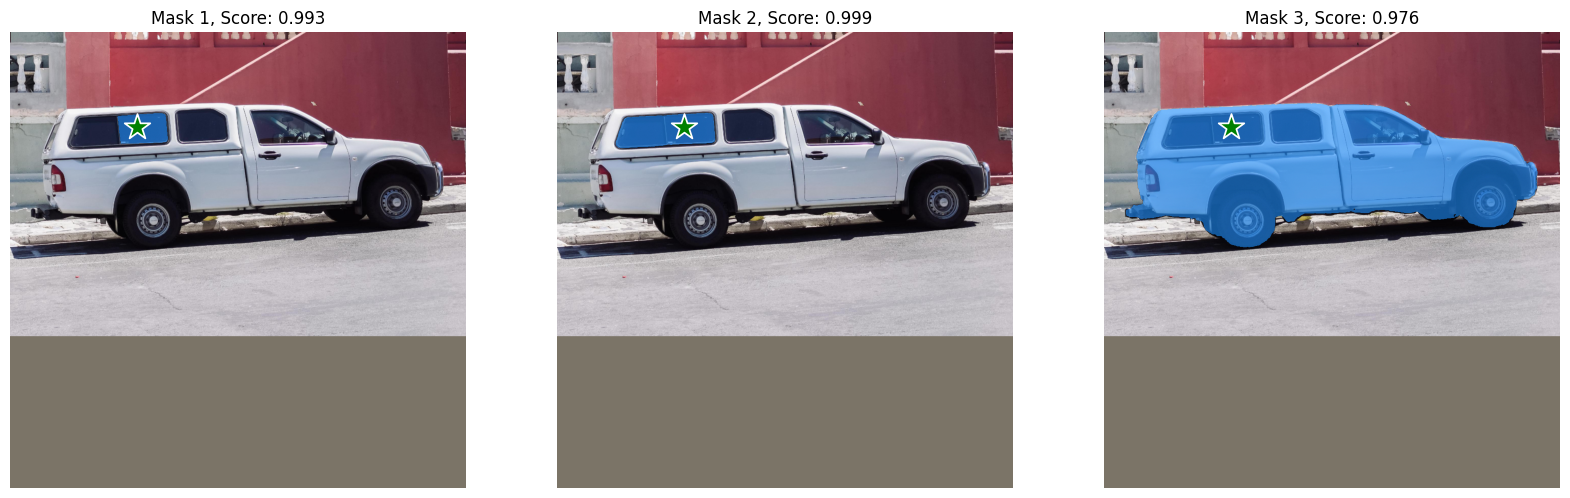

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 60))
masks, scores = outputs["masks"][0][1:], outputs["iou_pred"][0][1:]
for i, (mask, score) in enumerate(zip(masks, scores)):
    mask = inference_resizing(mask[..., None], pad=False)[..., 0]
    mask, score = map(ops.convert_to_numpy, (mask, score))
    mask = 1 * (mask > 0.0)
    ax[i].imshow(ops.convert_to_numpy(image) / 255.0)
    show_mask(mask, ax[i])
    show_points(input_point, input_label, ax[i])
    ax[i].set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=12)
    ax[i].axis("off")
plt.show()

훌륭합니다!
SAM은 우리의 포인트 프롬프트의 모호성을 포착할 수 있었고,
다른 가능한 세그먼테이션 마스크도 반환했습니다.

## 상자 프롬프트

이제 상자를 사용하여, 모델을 프롬프트하는 방법을 살펴보겠습니다.
상자는 두 점, 즉 xyxy 형식의 경계 상자의 왼쪽 상단 모서리와 오른쪽 하단 모서리를 사용하여 지정합니다.
트럭의 왼쪽 앞 타이어 주위에 경계 상자를 사용하여, 모델을 프롬프트해 보겠습니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


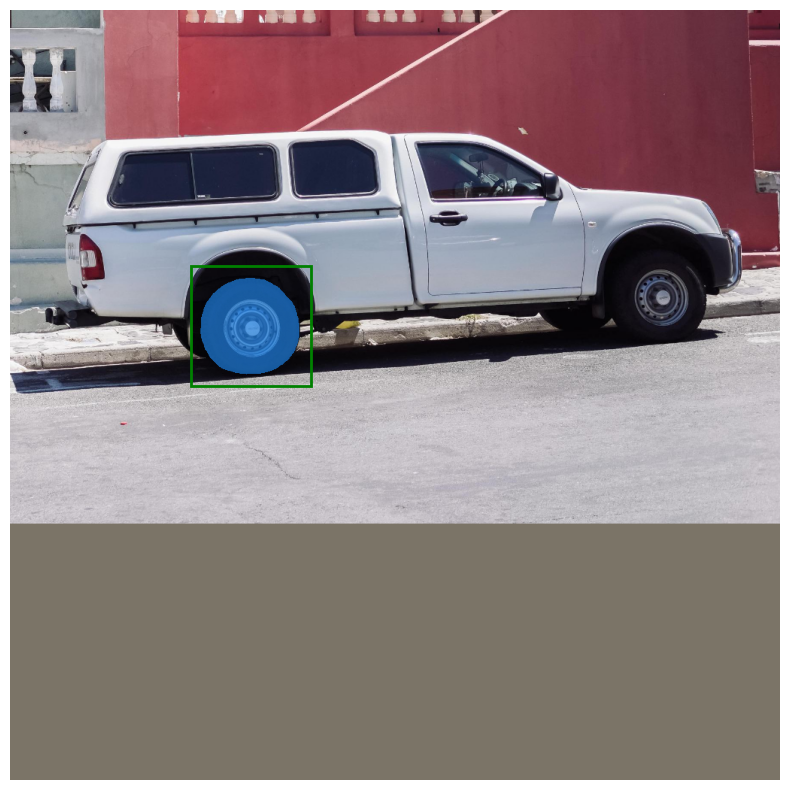

In [14]:
# 상자를 지정해 봅시다.
input_box = np.array([[240, 340], [400, 500]])

outputs = model.predict(
    {"images": image[np.newaxis, ...], "boxes": input_box[np.newaxis, np.newaxis, ...]}
)
mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
mask = ops.convert_to_numpy(mask) > 0.0

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
plt.axis("off")
plt.show()

붐! 이 모델은 경계 상자에서 왼쪽 앞 타이어를 완벽하게 세그멘테이션합니다.

## 프롬프트 결합

모델의 진정한 잠재력을 끌어내기 위해, 상자와 포인트의 프롬프트를 결합하고, 모델의 기능을 살펴보겠습니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


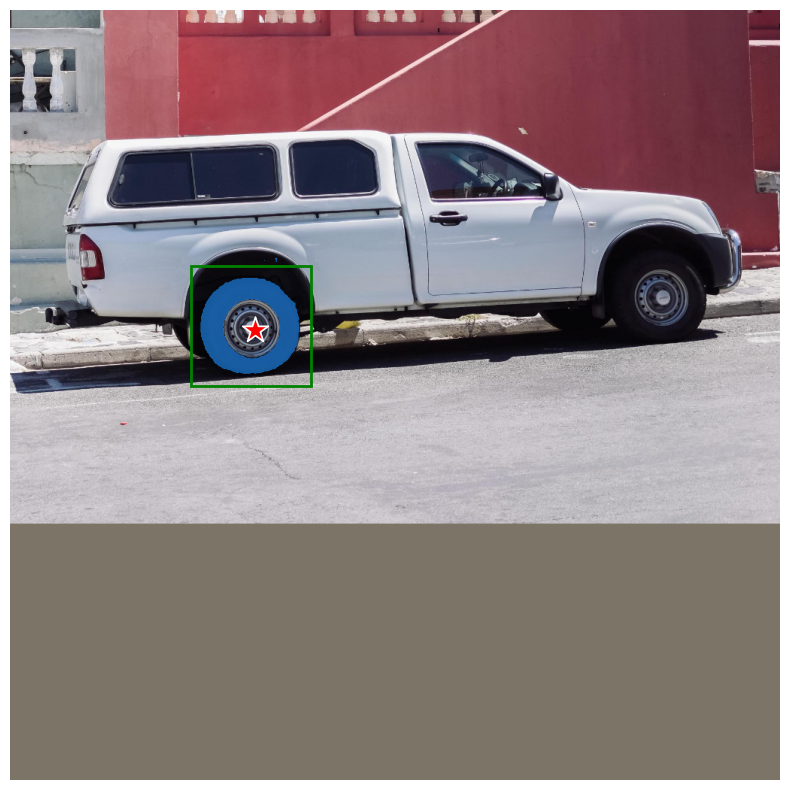

In [15]:
# 상자를 지정해 봅시다.
input_box = np.array([[240, 340], [400, 500]])
# 포인트를 지정하고, 배경으로 표시해 보겠습니다.
input_point = np.array([[325, 425]])
input_label = np.array([0])

outputs = model.predict(
    {
        "images": image[np.newaxis, ...],
        "points": input_point[np.newaxis, ...],
        "labels": input_label[np.newaxis, ...],
        "boxes": input_box[np.newaxis, np.newaxis, ...],
    }
)
mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
mask = ops.convert_to_numpy(mask) > 0.0

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis("off")
plt.show()

짠! 모델은 우리가 마스크에서 제외하려는 대상이 타이어의 림이라는 것을 이해했습니다.

## 텍스트 프롬프트

마지막으로, KerasCV의 `SegmentAnythingModel`과 함께 텍스트 프롬프트를 사용하는 방법을 살펴보겠습니다.

이 데모에서는 [공식 Grounding DINO 모델](https://github.com/IDEA-Research/GroundingDINO)을 사용합니다.
Grounding DINO는 `(image, text)` 쌍을 입력으로 받고,
`text`로 설명된 `image`의 객체 주위에 경계 상자를 생성하는 모델입니다.
모델 구현에 대한 자세한 내용은 [논문](https://arxiv.org/abs/2303.05499)을 참조하세요.

이 데모의 이 부분에서는, 소스에서 `groundingdino` 패키지를 설치해야 합니다.

```shell
pip install -U git+https://github.com/IDEA-Research/GroundingDINO.git
```

그런 다음, 사전 트레이닝된 모델의 가중치와 구성을 설치할 수 있습니다.

In [16]:
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/v0.1.0-alpha2/groundingdino/config/GroundingDINO_SwinT_OGC.py

In [18]:
!pip install groundingdino-py # install the GroundingDINO package

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 19.8 MB/s eta 0:00:00

In [19]:
from groundingdino.util.inference import Model as GroundingDINO

CONFIG_PATH = "GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "groundingdino_swint_ogc.pth"

grounding_dino = GroundingDINO(CONFIG_PATH, WEIGHTS_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

이 부분에서는 개 이미지를 불러오겠습니다!

1236492/1236492 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


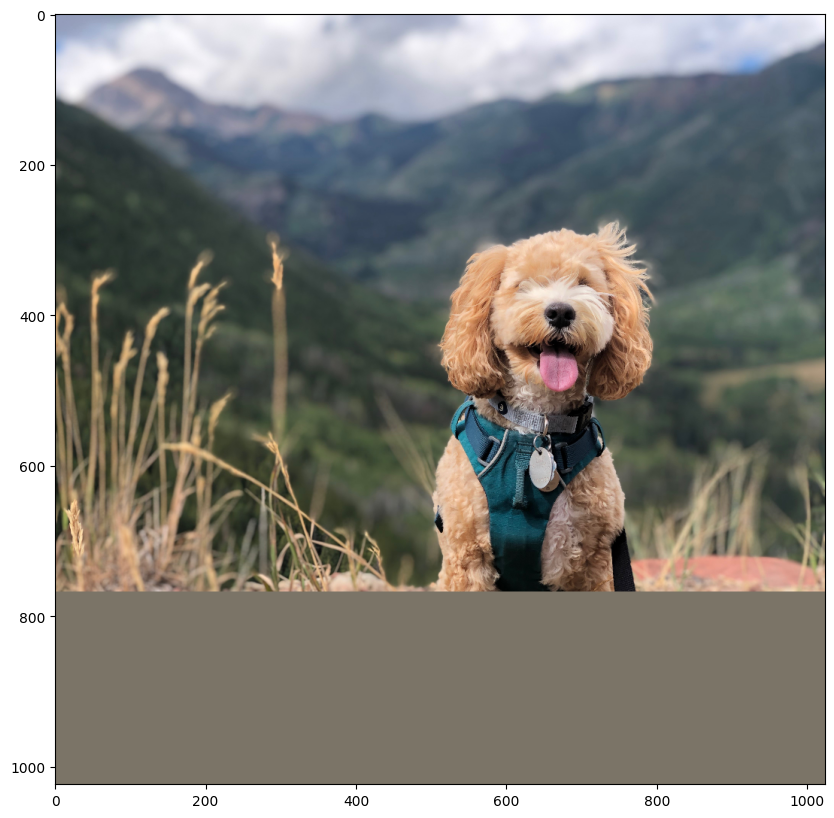

In [20]:
filepath = keras.utils.get_file(
    origin="https://storage.googleapis.com/keras-cv/test-images/mountain-dog.jpeg"
)
image = np.array(keras.utils.load_img(filepath))
image = ops.convert_to_numpy(inference_resizing(image))

plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)
plt.axis("on")
plt.show()

먼저 Grounding DINO 모델을 사용하여,
세그멘테이션하려는 객체의 바운딩 박스를 예측합니다.
그런 다음, 바운딩 박스를 사용하여 SAM 모델을 프롬프트하여,
세그멘테이션 마스크를 얻습니다.

개의 하네스를 세그멘테이션해 보겠습니다.
아래의 이미지와 텍스트를 변경하여, 이미지의 텍스트를 사용하여 원하는 대로 세그멘테이션하세요!

In [21]:
# 개의 하네스에 대한 경계 상자를 예측해 봅시다.
boxes = grounding_dino.predict_with_caption(image.astype(np.uint8), "harness")
boxes = np.array(boxes[0].xyxy)

outputs = model.predict(
    {
        "images": np.repeat(image[np.newaxis, ...], boxes.shape[0], axis=0),
        "boxes": boxes.reshape(-1, 1, 2, 2),
    },
    batch_size=1,
)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


그리고 그게 전부입니다!
Gounding DINO + SAM의 조합을 사용하여,
텍스트 프롬프트에 대한 세그멘테이션 마스크를 얻었습니다!
이것은 다양한 모델을 결합하여 응용 프로그램을 확장하는 매우 강력한 기술입니다!

결과를 시각화해 보겠습니다.

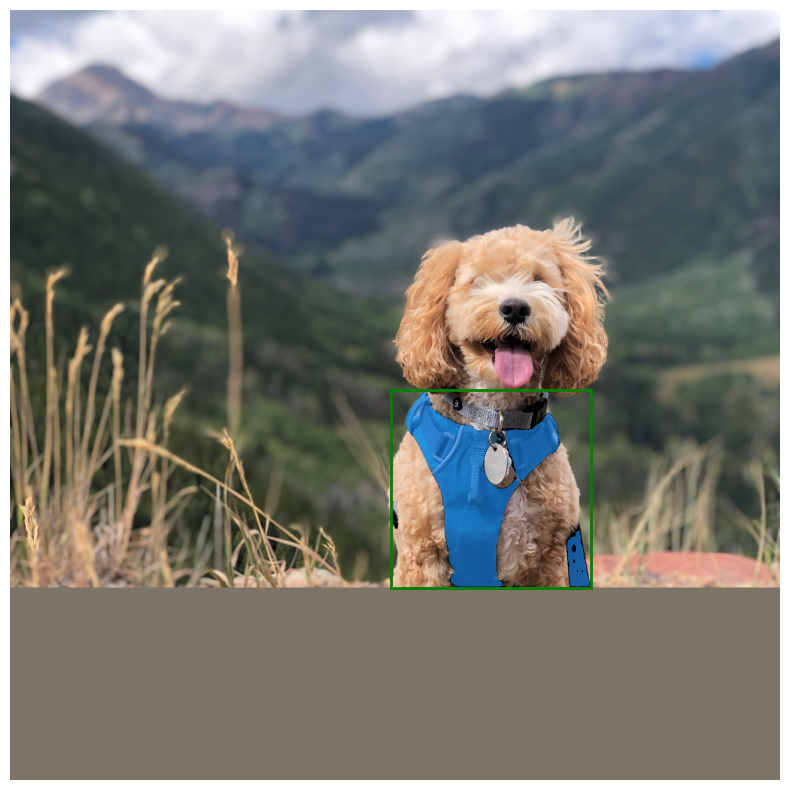

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)

for mask in outputs["masks"]:
    mask = inference_resizing(mask[0][..., None], pad=False)[..., 0]
    mask = ops.convert_to_numpy(mask) > 0.0
    show_mask(mask, plt.gca())
    show_box(boxes, plt.gca())

plt.axis("off")
plt.show()

## SAM 최적화

`mixed_float16` 또는 `bfloat16` dtype 정책을 사용하면,
상대적으로 낮은 정밀도 손실로 엄청난 속도 향상과 메모리 최적화를 얻을 수 있습니다.

In [23]:
# 이미지를 로드합니다.
image = np.array(keras.utils.load_img("truck.jpg"))
image = inference_resizing(image)

# 프롬프트를 지정합니다.
input_box = np.array([[240, 340], [400, 500]])

# 먼저 float32 dtype을 사용할 때, 모델이 얼마나 빠른지 살펴보겠습니다.
time_taken = timeit.repeat(
    'model.predict({"images": image[np.newaxis, ...], "boxes": input_box[np.newaxis, np.newaxis, ...]}, verbose=False)',
    repeat=3,
    number=3,
    globals=globals(),
)
print(f"Time taken with float32 dtype: {min(time_taken) / 3:.10f}s")

# Keras에서 dtype 정책 설정
keras.mixed_precision.set_global_policy("mixed_float16")

model = keras_cv.models.SegmentAnythingModel.from_preset("sam_huge_sa1b")

time_taken = timeit.repeat(
    'model.predict({"images": image[np.newaxis, ...], "boxes": input_box[np.newaxis, np.newaxis, ...]}, verbose=False)',
    repeat=3,
    number=3,
    globals=globals(),
)
print(f"Time taken with float16 dtype: {min(time_taken) / 3:.10f}s")

Time taken with float32 dtype: 0.2940748537s


TypeError: <class 'keras_cv.src.models.segmentation.segment_anything.sam.SegmentAnythingModel'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras_cv.src.models.segmentation.segment_anything.sam', 'class_name': 'SegmentAnythingModel', 'config': {'name': 'segment_anything_model', 'trainable': True, 'backbone': <ViTDetBackbone name=vi_t_det_backbone_2, built=True>, 'prompt_encoder': <SAMPromptEncoder name=sam_prompt_encoder_2, built=True>, 'mask_decoder': <SAMMaskDecoder name=sam_mask_decoder_2, built=True>}, 'registered_name': 'keras_cv.models>SegmentAnythingModel', 'weights': 'model.weights.h5'}.

Exception encountered: Exception encountered when calling SAMMaskDecoder.call().

[1mCould not automatically infer the output shape / dtype of 'sam_mask_decoder_2' (of type SAMMaskDecoder). Either the `SAMMaskDecoder.call()` method is incorrect, or you need to implement the `SAMMaskDecoder.compute_output_spec() / compute_output_shape()` method. Error encountered:

Exception encountered when calling TwoWayTransformer.call().

[1mInput 'y' of 'AddV2' Op has type float32 that does not match type float16 of argument 'x'.[0m

Arguments received by TwoWayTransformer.call():
  • image_embedding=tf.Tensor(shape=(None, 64, 64, 256), dtype=float32)
  • image_pe=tf.Tensor(shape=(None, 64, 64, 256), dtype=float32)
  • point_embedding=tf.Tensor(shape=(None, None, 256), dtype=float32)[0m

Arguments received by SAMMaskDecoder.call():
  • args=({'image_embeddings': '<KerasTensor shape=(None, 64, 64, 256), dtype=float32, sparse=False, name=keras_tensor_398>', 'image_pe': '<KerasTensor shape=(None, 64, 64, 256), dtype=float32, sparse=False, name=keras_tensor_408>', 'sparse_prompt_embeddings': '<KerasTensor shape=(None, None, 256), dtype=float32, sparse=False, name=keras_tensor_409>', 'dense_prompt_embeddings': '<KerasTensor shape=(None, 64, 64, 256), dtype=float32, sparse=False, name=keras_tensor_407>'},)
  • kwargs=<class 'inspect._empty'>

KerasCV 구현과 원본 PyTorch 구현을 비교한 것은 다음과 같습니다!

![benchmark](https://github.com/tirthasheshpatel/segment_anything_keras/blob/main/benchmark.png?raw=true)

벤치마크를 생성하는데 사용된 스크립트는 [여기](https://github.com/tirthasheshpatel/segment_anything_keras/blob/main/Segment_Anything_Benchmarks.ipynb)에 있습니다.

## 결론

KerasCV의 `SegmentAnythingModel`은 다양한 애플리케이션을 지원하고,
Keras 3의 도움으로 TensorFlow, JAX, PyTorch에서 모델을 실행할 수 있습니다!
JAX와 TensorFlow의 XLA의 도움으로, 모델은 원래 구현보다 몇 배 더 빠르게 실행됩니다.
게다가 Keras의 혼합 정밀도 지원을 사용하면,
단 한 줄의 코드로 메모리 사용과 계산 시간을 최적화하는 데 도움이 됩니다!

더 고급 사용 사례는 [자동 마스크 생성기 데모](https://github.com/tirthasheshpatel/segment_anything_keras/blob/main/Segment_Anything_Automatic_Mask_Generator_Demo.ipynb)를 확인하세요.
